In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [167]:
data_df = pd.read_csv('../Resources/Files/healthcare-dataset-stroke-data.csv')

data_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Attribute Information
- 1) id: unique identifier
- 2) gender: "Male", "Female" or "Other"
- 3) age: age of the patient
- 4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- 5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- 6) ever_married: "No" or "Yes"
- 7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- 8) Residence_type: "Rural" or "Urban"
- 9) avg_glucose_level: average glucose level in blood
- 10) bmi: body mass index
- 11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- 12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [168]:
print('The shape of this data set is: ', data_df.shape)

The shape of this data set is:  (5110, 12)


In [169]:
# let's get a unique count of values for each column to
# determine whether the column is continuous or categorical

column_dict = {}
for column in list(data_df.columns):
    column_dict[column] = data_df[column].value_counts().shape[0]
    
pd.DataFrame(column_dict, index = ['unique count']).transpose()

,unique count
id,5110
gender,3
age,104
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,3979
bmi,418


In [170]:
# we see above that there are 104 different ages. decimal ages aren't
# helpful. Let's see what the age distribution is so that we can
# decide whether to round up to 1 or take a different action

data_df['age'].describe().transpose()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

Text(0, 0.5, '')

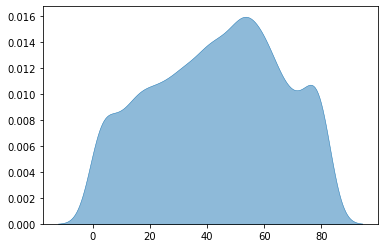

In [171]:
background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]

fig = sns.kdeplot(data=data_df, 
            x='age',
            fill=True, 
            palette=["#8000ff","#da8829"], 
            alpha=.5, 
            linewidth=0.5)
fig.set_xlabel("")
fig.set_ylabel("")

In [172]:
# How many individuals exactly in this data set are under 1?

data_df.loc[data_df['age'] < 1, ['age']].shape[0]

43

Text(0, 0.5, '')

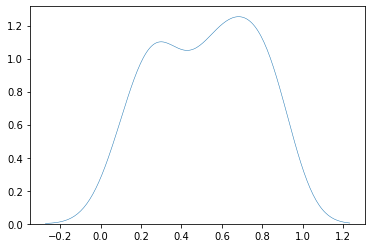

In [173]:
# let's look at the distribution of those under the age of 1
under_1_df = data_df.loc[data_df['age'] < 1, :]
fig = sns.kdeplot(data = under_1_df,
           x = 'age',
           fill = False,
           palette = ['#80000ff', '#da8829'],
           alpha = .5,
           linewidth = 0.5)
fig.set_xlabel('')
fig.set_ylabel('')

In [174]:
# as we can see here, the age goes under 0. I want to check one more
# time to see if that's actually the case, when we asked pandas
# to describe the age for us it didn't indicate there were negative
# values so I just want to check to make sure.

under_1_df['age'].value_counts()

0.72    5
0.56    5
0.88    5
0.32    5
0.24    5
0.64    4
0.80    4
0.48    3
0.16    3
0.40    2
0.08    2
Name: age, dtype: int64

In [175]:
# great, so no negative values. The accuracy of these ages is
# interesting, I don't want this to mess up the model and over-bias
# the model, so we will simply round this up to 1 and 0.5

data_df['age'] = np.where(data_df['age'].between(0.5,1),
                          1, 
                          data_df['age'])

data_df['age'] = data_df['age'].mask(data_df['age'] <= 0.5, 0.5)

In [176]:
# we can come back to this later if we feel we need to round down to
# zero for the ages between 0 and 0.5

under_1_df = data_df.loc[data_df['age'] <= 1, :]
under_1_df['age'].value_counts()

1.0    28
0.5    20
Name: age, dtype: int64

In [177]:
# cool, so we fixed the age issue. next we come across gender. gender
# really should be sex in this case, and let's see how many others there
# are to determine whether removing them from the data set will impact
# the predictions. later on we can include them, but right now we want to
# be as accurate as possible and gain as much knowledge on the differences
# between males and females and not worry about other. maybe after we do
# males and females we can include other to see how it affects data,
# because maybe those who 'identify' as 'other' exhibit behaviors in
# their lifestyles to justify actually considering how those behaviors
# impact their physical health. 

data_df = data_df.rename(columns = {'gender': 'sex'})
data_df['sex'].value_counts()

Female    2994
Male      2115
Other        1
Name: sex, dtype: int64

In [178]:
# as we can see here, there is only one 'other', so we can simply drop
# this row with minimal repurcussions in our analysis and predictions.

data_df = data_df.loc[data_df['sex'] != 'Other',:]

data_df = data_df.rename(columns = {'gender': 'sex'})
data_df['sex'].value_counts()

Female    2994
Male      2115
Name: sex, dtype: int64

In [179]:
# next, we consider work type, which is covered by the 'work_type'
# column. work type can be important is it could indicate the level of
# stress a particular patient is experiencing. so we will keep it.

In [180]:
# our last column that we will consider is smoking status. the one issue
# that i can see needing to be fixed is the unknown. Let's consider how
# many unknowns there are prior to determining what to do, as it could
# simply be so few that we can remove them from the set without worrying
# too much about impact on the analysis
smoking_values = data_df['smoking_status'].value_counts().index
smoking_status = data_df['smoking_status'].value_counts().tolist()
for i in range(0, len(smoking_status)):
    print(smoking_values[i], ' --- ', smoking_status[i])

never smoked  ---  1892
Unknown  ---  1544
formerly smoked  ---  884
smokes  ---  789


In [181]:
# because unknown is a significant portion of the data set, let's 
# distribute them proportionally to the other categories, as this
# will help maintain balance. Because of this, it can be said that
# we are assuming these values are randomly selected and that the 
# patients were not intentionally picked because of certain habits.

never_smoked_ratio = smoking_status[0]/(smoking_status[0] + smoking_status[2] + smoking_status[3])
formerly_smoked_ratio = smoking_status[2]/(smoking_status[2] + smoking_status[3]) 
smokes_ratio = smoking_status[3]/smoking_status[3]

# let's get the id's of the unknowns so that we can randomly pick from
# them and alter their "smoking_status" value to one of the other
# categories

list_of_ids = data_df.loc[data_df['smoking_status'] == 'Unknown',
                         ['id']]['id']

In [182]:
to_be_never_smoked = list_of_ids.sample(frac = never_smoked_ratio).tolist()
for id_ in to_be_never_smoked:
    to_be_changed = data_df.loc[data_df['id'] == id_,:]
    to_be_changed = to_be_changed.mask(to_be_changed['smoking_status'] == 'Unknown',
                                      'never smoked')
    data_df.loc[data_df['id'] == id_,['smoking_status']] = to_be_changed['smoking_status']

list_of_ids = data_df.loc[data_df['smoking_status'] == 'Unknown',
                         ['id']]['id']

####################################################################
to_be_formerly_smoked = list_of_ids.sample(frac = formerly_smoked_ratio).tolist()
for id_ in to_be_formerly_smoked:
    to_be_changed = data_df.loc[data_df['id'] == id_,:]
    to_be_changed = to_be_changed.mask(to_be_changed['smoking_status'] == 'Unknown',
                                      'formerly smoked')
    data_df.loc[data_df['id'] == id_,['smoking_status']] = to_be_changed['smoking_status']
    
list_of_ids = data_df.loc[data_df['smoking_status'] == 'Unknown',
                         ['id']]['id']

####################################################################
to_be_smokes = list_of_ids.sample(frac = smokes_ratio).tolist()
for id_ in to_be_smokes:
    to_be_changed = data_df.loc[data_df['id'] == id_,:]
    to_be_changed = to_be_changed.mask(to_be_changed['smoking_status'] == 'Unknown',
                                      'smokes')
    data_df.loc[data_df['id'] == id_,['smoking_status']] = to_be_changed['smoking_status']

In [183]:
after_count = data_df['smoking_status'].value_counts()
print(after_count)
print('never_smoked ratio before versus after:',
     '\nnever smoked before: ', never_smoked_ratio, '- after: ', after_count[0]/5110,
     '\nformerly smoked before: ', formerly_smoked_ratio, '- after', after_count[1]/(after_count[1] + after_count[2]),
      '\nsmokes before: ', smokes_ratio, '- after', after_count[2]/after_count[2])

never smoked       2711
formerly smoked    1267
smokes             1131
Name: smoking_status, dtype: int64
never_smoked ratio before versus after: 
never smoked before:  0.5307152875175316 - after:  0.5305283757338551 
formerly smoked before:  0.5283921099820681 - after 0.5283569641367807 
smokes before:  1.0 - after 1.0


ValueError: The palette list has the wrong number of colors.

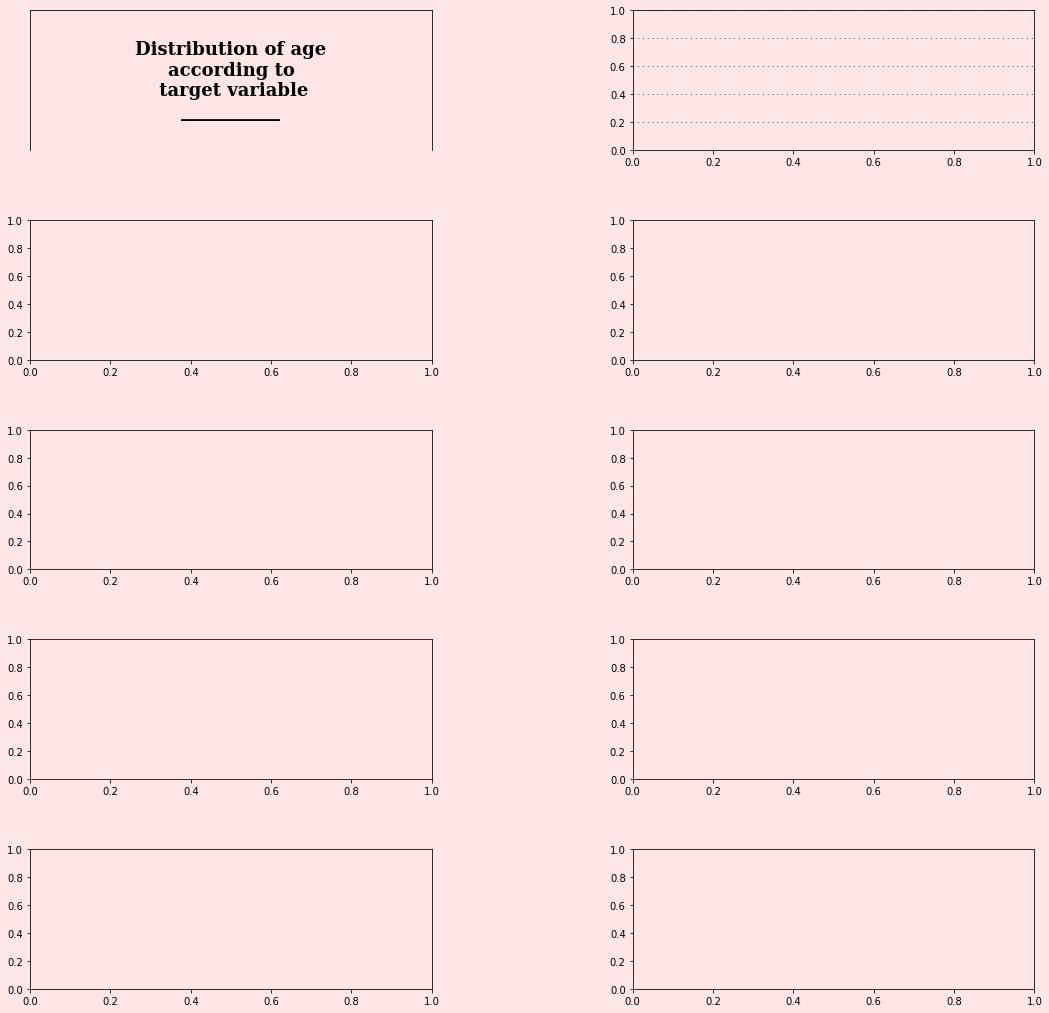

In [184]:
# we have successfully redistributed the unknowns!  Now for the
# visualizations and correlation matrices, etc

fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(5,2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,0])
ax9 = fig.add_subplot(gs[4,1])

background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color) 
ax6.set_facecolor(background_color) 
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)
ax9.set_facecolor(background_color)

# Age title
ax0.text(0.5,0.5,"Distribution of age\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax0.spines["bottom"].set_visible(False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Age
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax1, data=data_df, x='age',hue="stroke", fill=True, palette=color_palette, alpha=.5, linewidth=0)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Sex title
ax2.text(0.5,0.5,"Distribution of sex\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax2.spines["bottom"].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.tick_params(left=False, bottom=False)

# Sex
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax3, data=data_df, x='sex',hue="stroke", fill=True, palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Hypertension title
ax4.text(0.5,0.5,"Distribution of hyptertension\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax4.spines["bottom"].set_visible(False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.tick_params(left=False, bottom=False)

# Hypertension
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax5, data=data_df, x='hypertension',hue="hyptertension", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax5.set_xlabel("")
ax5.set_ylabel("")

# Heart disease title
ax6.text(0.5,0.5,"Distribution of heart disease\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax6.spines["bottom"].set_visible(False)
ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.tick_params(left=False, bottom=False)

# Heart disease
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax7, data=data_df, x='heart_disease',hue="stroke", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Average glucose level title
ax8.text(0.5,0.5,"Distribution of average glucose level\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax8.spines["bottom"].set_visible(False)
ax8.set_xticklabels([])
ax8.set_yticklabels([])
ax8.tick_params(left=False, bottom=False)

# Average Glucose Level
ax9.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax9, data=data_df, x='avg_glucose_level',hue="stroke", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax9.set_xlabel("")
ax9.set_ylabel("")

for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)
    ax6.spines[i].set_visible(False)
    ax7.spines[i].set_visible(False)
    ax8.spines[i].set_visible(False)
    ax9.spines[i].set_visible(False)

In [185]:
# once again, let's get a unique count of values for each column to
# determine whether the column is continuous or categorical

column_dict = {}
for column in list(data_df.columns):
    column_dict[column] = data_df[column].value_counts().shape[0]
    
pd.DataFrame(column_dict, index = ['unique count']).transpose()

,unique count
id,5109
sex,2
age,94
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,3978
bmi,418


In [186]:
# first thing we want to do is determine the categorical and continuous
# categories, so we will go ahead and do that now

cat_cols = ['sex','age',
            'hypertension',
            'heart_disease',
            'ever_married',
            'work_type',
           'Residence_type',
           'smoking_status']
con_cols = ['age','avg_glucose_level','bmi']
target_col = ['stroke']
print('the categorical columns are: ',cat_cols)
print('the continuous columns are: ', con_cols)
print('the target column is: ', target_col)

the categorical columns are:  ['sex', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
the continuous columns are:  ['age', 'avg_glucose_level', 'bmi']
the target column is:  ['stroke']


Yes    3353
No     1756
Name: ever_married, dtype: int64